Main goal: Goal：use the other variables and spatial information to predict which type each building belongs to

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from sklearn import ensemble, metrics, model_selection

In [5]:
building_data = gpd.read_file(
  "https://martinfleischmann.net/sds/chapter_11/data/prg_building_locations.gpkg",
  engine="pyogrio",
)
building_data.head()

,cluster,floor_area_ratio,height,compactness,street_alignment,interbuilding_distance,block_perimeter_wall_length,basic_settlement_unit,cadastral zone,geometry
0,large-scale industry,0.614375,23.458,0.747131,10.601522,37.185479,57.751467,U cementárny,Radotín,POINT (-749841.681 -1052279.951)
1,medieval city,2.993299,16.099,0.469154,8.655982,8.547983,1033.921828,Horní malostranský obvod,Malá Strana,POINT (-744432.289 -1042699.409)
2,periphery,0.108374,3.673,0.498831,2.473966,26.135688,74.432812,Dolní Měcholupy-střed,Dolní Měcholupy,POINT (-733300.261 -1048136.856)
3,periphery,0.290723,9.097,0.627294,6.054875,32.423481,38.592030,Trojský obvod,Troja,POINT (-742468.177 -1039691.997)
4,grids,0.017193,4.216,0.540439,0.134446,48.068409,49.125654,Vrch Svatého kříže,Žižkov,POINT (-740093.985 -1043857.813)


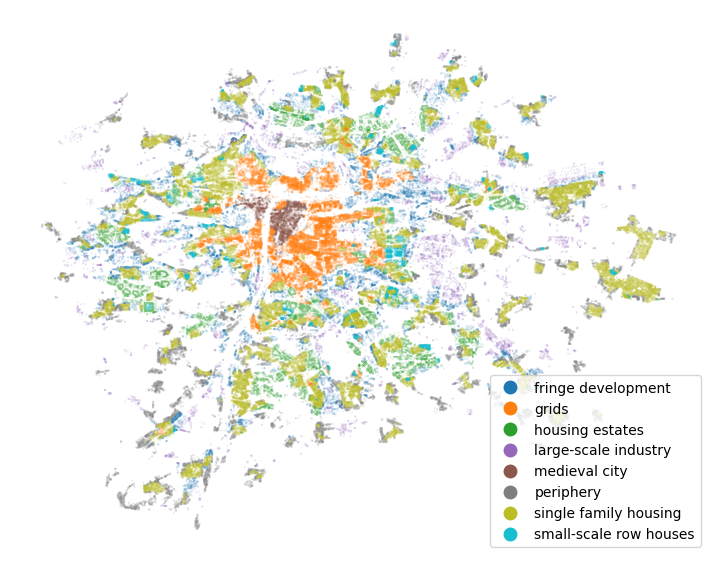

In [7]:
ax = building_data.plot(
    "cluster", legend=True, figsize=(9, 9), markersize=0.005
)
ax.set_axis_off()

In [6]:
# extract topic variables
independent_variables = [
    "floor_area_ratio",
    "height",
    "compactness",
    "street_alignment",
    "interbuilding_distance",
    "block_perimeter_wall_length",
]

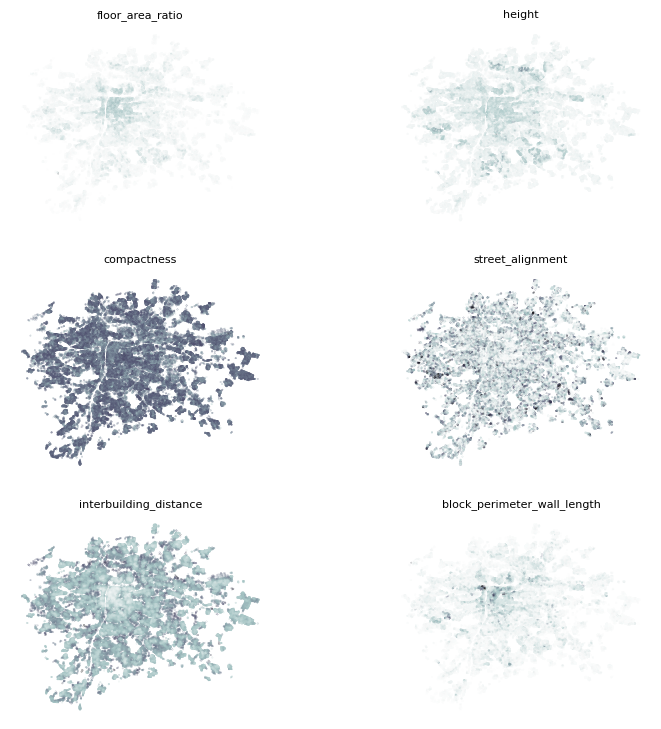

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(9, 9))
axs = axs.flatten()
for i, var in enumerate(independent_variables):
    building_data.plot(var, markersize=0.01, cmap="bone_r", ax=axs[i])
    axs[i].set_title(var, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

## Traning Data Prepare

In [9]:
training_sample = building_data.sample(20_000, random_state=0)

In [10]:
independent = training_sample[independent_variables]
independent.head(2)

,floor_area_ratio,height,compactness,street_alignment,interbuilding_distance,block_perimeter_wall_length
34984,0.139151,4.833,0.321089,0.615831,26.019856,72.103088
39935,2.209054,20.939,0.584905,2.867204,21.971761,1107.995952


In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, training_sample["cluster"], test_size=0.25, random_state=0
)

## Random Forest Classifier

In [12]:
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [13]:
pred = model.predict(X_test)
pred

array(['single family housing', 'single family housing', 'medieval city',
       ..., 'single family housing', 'grids', 'single family housing'],
      dtype=object)

In [14]:
proba = model.predict_proba(X_test)
proba

array([[0.01, 0.19, 0.06, ..., 0.04, 0.43, 0.24],
       [0.01, 0.  , 0.  , ..., 0.13, 0.86, 0.  ],
       [0.  , 0.2 , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.03, 0.11, 0.  , ..., 0.06, 0.51, 0.29],
       [0.  , 0.98, 0.  , ..., 0.  , 0.  , 0.02],
       [0.07, 0.19, 0.04, ..., 0.  , 0.51, 0.09]])

In [15]:
model.classes_

array(['fringe development', 'grids', 'housing estates',
       'large-scale industry', 'medieval city', 'periphery',
       'single family housing', 'small-scale row houses'], dtype=object)

In [16]:
pd.DataFrame(proba, columns=model.classes_, index=X_test.index)

,fringe development,grids,housing estates,large-scale industry,medieval city,periphery,single family housing,small-scale row houses
42677,0.01,0.19,0.06,0.03,0.00,0.04,0.43,0.24
72818,0.01,0.00,0.00,0.00,0.00,0.13,0.86,0.00
8884,0.00,0.20,0.00,0.00,0.80,0.00,0.00,0.00
85469,0.25,0.00,0.01,0.01,0.00,0.08,0.65,0.00
111045,0.43,0.01,0.03,0.25,0.00,0.27,0.01,0.00
...,...,...,...,...,...,...,...,...
17114,0.62,0.00,0.05,0.06,0.00,0.22,0.05,0.00
33641,0.02,0.02,0.00,0.00,0.00,0.32,0.63,0.01
119950,0.03,0.11,0.00,0.00,0.00,0.06,0.51,0.29
22551,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.02


## Evaluation training result

In [17]:
accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.582
  Kappa:    0.446



In [18]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

compactness                    0.125236
street_alignment               0.125571
floor_area_ratio               0.166084
height                         0.174317
block_perimeter_wall_length    0.187524
interbuilding_distance         0.221269
dtype: float64

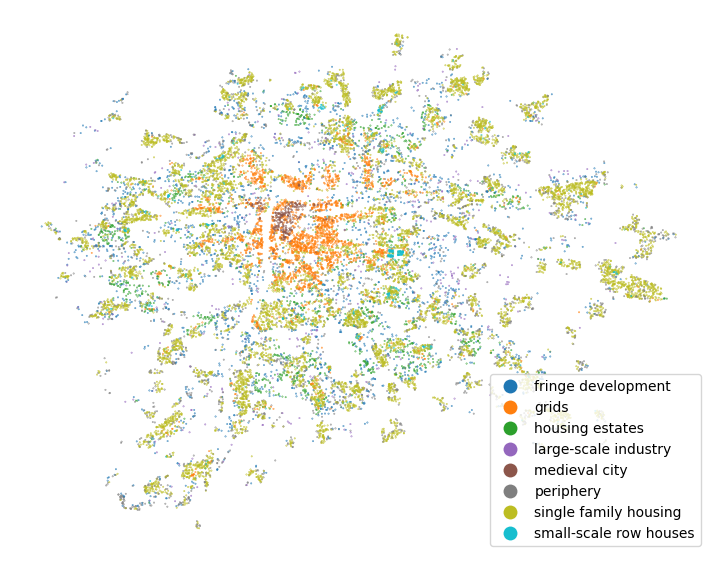

In [19]:
predicted = model_selection.cross_val_predict(
    model, independent, training_sample["cluster"], cv=4, n_jobs=-1
)

ax = training_sample.plot(predicted, legend=True, figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

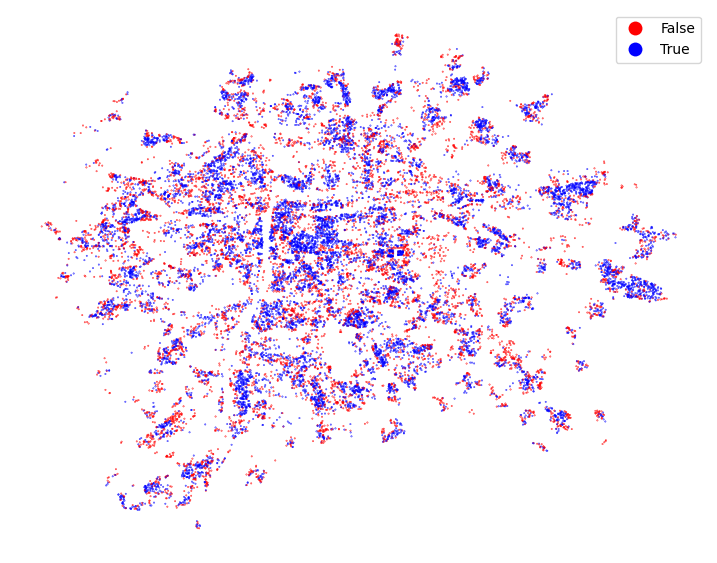

In [20]:
ax = training_sample.plot(
    predicted == training_sample["cluster"],
    categorical=True,
    figsize=(9, 9),
    markersize=0.1,
    cmap="bwr_r",
    legend=True,
)
ax.set_axis_off()

as with the linear regression, a spatial autocorrelation of errors means that the model does not represent space reliably and may need some adaptations.

## Spatial cross-validation

In [21]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    training_sample,
    training_sample.cluster,
    groups=training_sample.basic_settlement_unit,
)

In [22]:
split_label = np.empty(len(training_sample), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i
training_sample["split"] = split_label

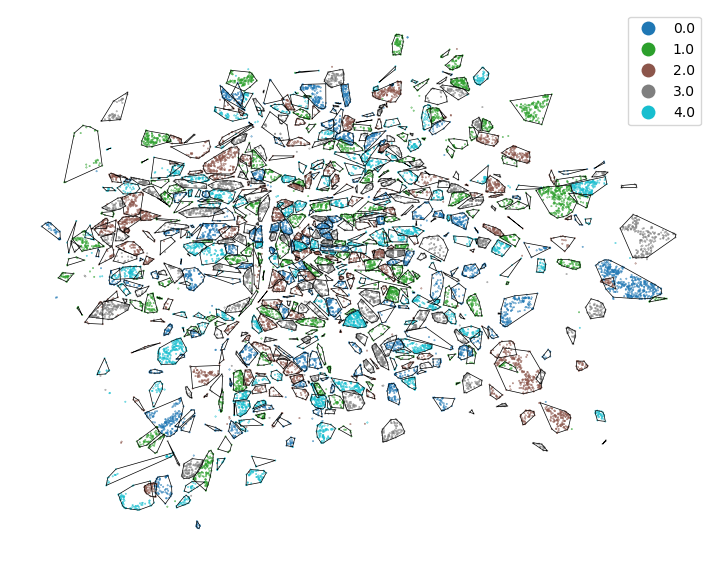

In [23]:
ax = training_sample.plot(
  "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
)
training_sample.dissolve("basic_settlement_unit").convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.5, markersize=0
)
ax.set_axis_off()

In [24]:
train = training_sample["split"] != 0
X_train = independent.loc[train]
y_train = training_sample["cluster"].loc[train]

test = training_sample["split"] == 0
X_test = independent.loc[test]
y_test = training_sample["cluster"].loc[test]

In [25]:
rf_spatial_cv = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_spatial_cv.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [26]:
pred = rf_spatial_cv.predict(X_test)

accuracy_spatial_cv = metrics.accuracy_score(pred, y_test)
kappa_spatial_cv = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Basic model with spatial cross-validation:
  Accuracy: {round(accuracy_spatial_cv, 3)}
  Kappa:    {round(kappa_spatial_cv, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.582
  Kappa:    0.446
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419



The result is worse on paper but is now more spatially robust - it will generalize better on unseen data.

## Feature engineering

In [27]:
distance_200 = graph.Graph.build_distance_band(training_sample, 200)
training_sample["points_in_200m"] = distance_200.cardinalities

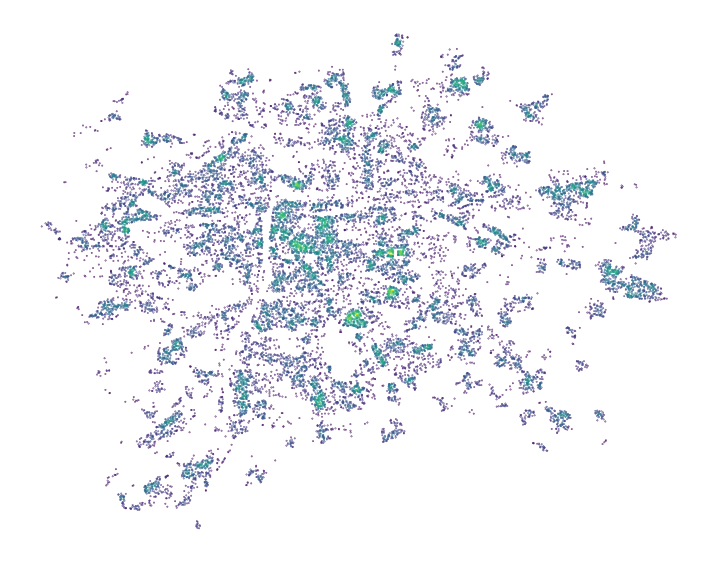

In [28]:
ax = training_sample.plot("points_in_200m", figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

In [29]:
independent_proximity = training_sample[
    independent_variables + ["points_in_200m"]
]

X_train = independent_proximity.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_proximity.loc[test]
y_test = training_sample["cluster"].loc[test]

In [30]:
rf_proximity = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_proximity.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [31]:
pred = rf_proximity.predict(X_test)

accuracy_proximity = metrics.accuracy_score(pred, y_test)
kappa_proximity = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Points within 200m (spatial CV):
  Accuracy: {round(accuracy_proximity, 3)}
  Kappa:    {round(kappa_proximity, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.582
  Kappa:    0.446
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.599
  Kappa:    0.462



In [32]:
pd.Series(
    rf_proximity.feature_importances_, index=rf_proximity.feature_names_in_
).sort_values()

compactness                    0.108781
street_alignment               0.108891
points_in_200m                 0.127389
floor_area_ratio               0.146619
height                         0.159468
block_perimeter_wall_length    0.173601
interbuilding_distance         0.175250
dtype: float64

## Proximity variables

In [37]:
old_town_square = (
    gpd.tools.geocode("Old Town Square, Prague")
    .to_crs(building_data.crs)
    .geometry.item()
)

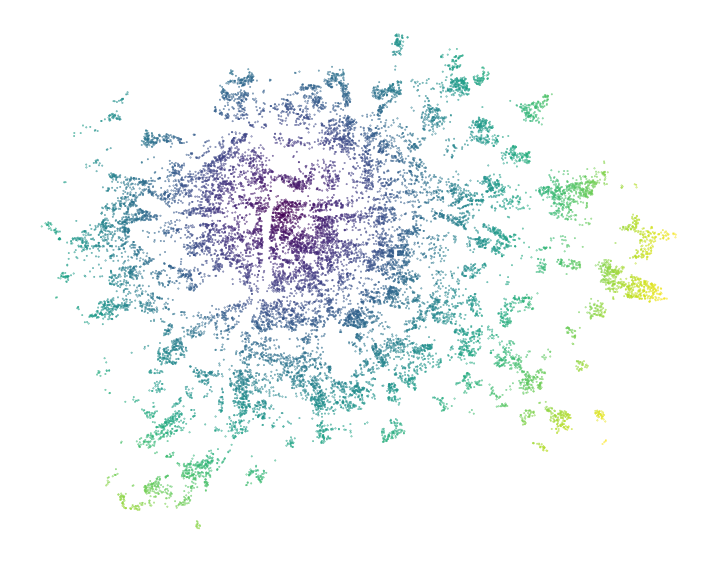

In [38]:
training_sample["distance_to_old_town"] = training_sample.distance(old_town_square)

ax = training_sample.plot("distance_to_old_town", figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

In [39]:
independent_distance = training_sample[
    independent_variables + ["points_in_200m", "distance_to_old_town"]
]

X_train = independent_distance.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_distance.loc[test]
y_test = training_sample["cluster"].loc[test]

In [40]:
rf_distance = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_distance.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [41]:
pred = rf_distance.predict(X_test)

accuracy_distance = metrics.accuracy_score(pred, y_test)
kappa_distance = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Distance to Old Town Sq + above (spatial CV):
  Accuracy: {round(accuracy_distance, 3)}
  Kappa:    {round(kappa_distance, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.582
  Kappa:    0.446
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.599
  Kappa:    0.462
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.653
  Kappa:    0.535



In [42]:
pd.Series(
    rf_distance.feature_importances_, index=rf_distance.feature_names_in_
).sort_values()

compactness                    0.083461
street_alignment               0.084540
points_in_200m                 0.115464
floor_area_ratio               0.118822
height                         0.122485
block_perimeter_wall_length    0.136500
interbuilding_distance         0.143194
distance_to_old_town           0.195535
dtype: float64

it seems to be more explanatory than any of the variables reflecting the actual morphology.